# ClusterLightGCN Model Experiment 

## Importing Required Libraries

In [1]:
# Standard Library Imports + Additional Libraries for Graph Related Tasks
import random
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import pymetis
pd.set_option('display.max_colwidth', None)

# PyTorch Standard Library Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

# Torch_Geometric Specific Imports
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_sparse import SparseTensor, matmul

# Model Training Libraries
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [2]:
torch_geometric.__version__

'2.2.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading MovieLens100k Dataset

In [4]:
# Downloading Dataset (MovieLens 100K)
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [5]:
rating_df = pd.read_csv(rating_path)
print("Dimensions of dataset: ",rating_df.shape)
display(rating_df.head())

Dimensions of dataset:  (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
num_items = len(rating_df['movieId'].unique())
num_users = len(rating_df['userId'].unique())

print("Number of Unique Users : ", num_users)
print("Number of unique Items : ", num_items)

Number of Unique Users :  610
Number of unique Items :  9724


In [7]:
# Encoding preprocessing to match no. of unique Ids
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

## Visualizing User-Item Interactions in Bipartite Graph

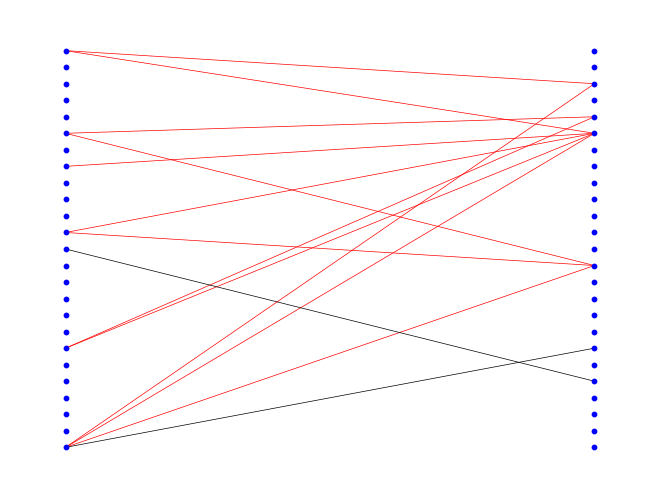

In [8]:
# Random subset of 50 users and 50 items
users = np.random.choice(rating_df['userId'].unique(), size=25, replace=False)
movies = np.random.choice(rating_df['movieId'].unique(), size=25, replace=False)

# Filter dataset and count no. of user-item interactions
ratings_subset = rating_df.loc[rating_df['userId'].isin(users) & rating_df['movieId'].isin(movies)]
item_counts = ratings_subset.groupby('movieId').size()

# Create bipartite graph
G = nx.Graph()
G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(movies, bipartite=1)
for idx, row in ratings_subset.iterrows():
    color = 'r' if item_counts[row['movieId']] > 1 else 'k'
    G.add_edge(row['userId'], row['movieId'], color=color)

# Draw bipartite graph
pos = {node:[0, i] for i, node in enumerate(users)}
pos.update({node:[1, i] for i, node in enumerate(movies)})
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
nx.draw(G, pos=pos, with_labels=False, node_size=10, width=0.5, node_color='b', edge_color=colors)

plt.show()

## Data Preprocessing: Building Graph in Edge-Index Format

In [9]:
# Extract user-item interactions
rating_threshold = 3.5 # only using high-quality ratings for training
rating_mask = rating_df['rating'].values > rating_threshold
user_ids = rating_df.loc[rating_mask, 'userId'].values
item_ids = rating_df.loc[rating_mask, 'movieId'].values
interactions = np.ones_like(user_ids)

In [10]:
# Create sparse COO matrix representing user-item interactions
coo = sp.coo_matrix((interactions, (user_ids, item_ids)))
row, col, data = coo.row, coo.col, coo.data

# Edge Index (converted as LongTensor)
edge_index = np.array([row, col])
edge_index = torch.LongTensor(edge_index)

In [11]:
print(coo.shape) # Interaction Matrix, R - (num_users, num_items)
# print(coo)

(610, 9724)


In [12]:
print(edge_index.shape)
print(edge_index)

torch.Size([2, 48580])
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])


## Train-Test-Validation Split

In [13]:
num_interactions = edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [14]:
print(f"Total No. Nodes: {(num_users + num_items)}")
print(f"num_users: {num_users}, num_items: {num_items}, num_interactions: {num_interactions}")

Total No. Nodes: 10334
num_users: 610, num_items: 9724, num_interactions: 48580


In [15]:
print(train_edge_index.size())
print(train_edge_index)

torch.Size([2, 38864])
tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])


In [16]:
print(val_edge_index.size())
print(val_edge_index)

torch.Size([2, 4858])
tensor([[ 111,  491,  582,  ...,  176,  478,  413],
        [1072,  656,  314,  ..., 5363,  450, 6993]])


In [17]:
print(test_edge_index.size())
print(test_edge_index)

torch.Size([2, 4858])
tensor([[ 559,  266,   57,  ...,  278,  201,   67],
        [5339,  898,  443,  ..., 8972, 1578, 1153]])


## Convert Interaction Matrix to Adjacency Matrix - Helper Functions

In [18]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    """
    Takes an edge index representing the user-item interaction matrix (R matrix)
    and returns an edge index representing the adjacency matrix.
    __________________________________
    
    Args:
        input_edge_index (LongTensor): Edge index of user-item interaction matrix (R matrix).
        
    Returns:
        adj_mat_coo (LongTensor): Edge index of adjacency matrix.
    """
    R = torch.zeros((num_users, num_items))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_items , num_users + num_items))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [19]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    """
    Takes an edge index representing the adjacency matrix and returns
    an edge index representing the user-item interaction matrix (R matrix).
    __________________________________
    
    Args:
        input_edge_index (LongTensor): Edge index of adjacency matrix.
        
    Returns:
        r_mat_edge_index (LongTensor): Edge index of user-item interaction matrix (R matrix).
    """
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           sparse_sizes=((num_users + num_items), num_users + num_items))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

## Convert from Interaction Edge Index to Adjacency Edge Index

In [20]:
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [21]:
print(train_edge_index)
print(train_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])


In [22]:
print(val_edge_index)
print(val_edge_index.size())

tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])


In [23]:
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


## Graph Partitioning

In [24]:
def partition_graph(train_edge_index, n_clusters):
    # Convert edge index to a NetworkX graph
    G = nx.Graph()
    G.add_edges_from(train_edge_index.T) # take transpose

    # Reindex nodes with consecutive integer node IDs
    node_mapping = {node: i for i, node in enumerate(G.nodes)}
    G_reindexed = nx.relabel_nodes(G, node_mapping)

    # Convert the graph to adjacency list format
    adjacency_list = [sorted(list(G_reindexed.neighbors(node))) for node in G_reindexed.nodes]

    # Cluster nodes using Pymetis
    (edgecuts, parts) = pymetis.part_graph(n_clusters, adjacency=adjacency_list)

    # Create a list to store edge indices for each cluster
    clustered_edge_indices = [ [] for _ in range(n_clusters)]

    # Fill the list with edges belonging to each cluster
    cluster_labels = np.array(parts)
    for edge in G_reindexed.edges:
        cluster = cluster_labels[edge[0]]
        if cluster == cluster_labels[edge[1]]:
            clustered_edge_indices[cluster].append(edge)
    
    # Convert each cluster's edge indices to a tensor and store in the list
    for i, cluster_edges in enumerate(clustered_edge_indices):
        r_edge_index = np.array(cluster_edges).T
        r_edge_index = torch.from_numpy(r_edge_index).type(torch.LongTensor)

        # Convert reindexed edge index to the original node IDs
        inv_node_mapping = {v: k for k, v in node_mapping.items()}
        r_edge_index = torch.tensor([[inv_node_mapping[int(idx)] for idx in r_edge_index[0]],
                                     [inv_node_mapping[int(idx)] for idx in r_edge_index[1]]])

        # Convert edge index format to that of the interaction matrix (R matrix)
        # r_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(r_edge_index)
        
        clustered_edge_indices[i] = r_edge_index

    return clustered_edge_indices # returns a list of tensors

## Generate Clustered Training Edge Index

In [25]:
n_clusters = 100
clustered_train_edge_index = partition_graph(train_edge_index, n_clusters)

In [26]:
print(clustered_train_edge_index) # List of Tensors

[tensor([[   17,    17,    19,  ..., 10294, 10300, 10333],
        [ 1560,  3196,  1999,  ...,    17,    24,   330]]), tensor([[   17,    50,    56,  ..., 10237, 10241, 10286],
        [ 7899,  1611,  1477,  ...,   413,   152,   461]]), tensor([[   17,    17,    18,  ..., 10030, 10089, 10113],
        [ 8362,  8562,  1599,  ...,   158,   338,   248]]), tensor([[    0,     5,    18,  ..., 10158, 10299, 10302],
        [  807,   652,  1604,  ...,   304,   555,   379]]), tensor([[    5,     5,    17,  ..., 10245, 10246, 10294],
        [  938,   969,  3070,  ...,   183,   183,    61]]), tensor([[   10,    16,    16,  ...,  9283,  9283, 10055],
        [ 1693,  2548,  4755,  ...,   330,   379,   379]]), tensor([[   16,    16,    16,  ..., 10301, 10312, 10323],
        [ 1548,  2834,  3058,  ...,    24,   183,   183]]), tensor([[    0,     0,     0,  ..., 10054, 10055, 10149],
        [  834,   901,  1071,  ...,    97,   585,   585]]), tensor([[    0,     3,     3,  ..., 10055, 10089, 10089

In [27]:
# Checking dimensions of edge index tensor for each cluster
for i, cluster_edge_index in enumerate(clustered_train_edge_index):
    print(f"Cluster {i}: {cluster_edge_index.shape}")

Cluster 0: torch.Size([2, 777])
Cluster 1: torch.Size([2, 777])
Cluster 2: torch.Size([2, 777])
Cluster 3: torch.Size([2, 777])
Cluster 4: torch.Size([2, 777])
Cluster 5: torch.Size([2, 778])
Cluster 6: torch.Size([2, 777])
Cluster 7: torch.Size([2, 777])
Cluster 8: torch.Size([2, 778])
Cluster 9: torch.Size([2, 777])
Cluster 10: torch.Size([2, 777])
Cluster 11: torch.Size([2, 778])
Cluster 12: torch.Size([2, 777])
Cluster 13: torch.Size([2, 778])
Cluster 14: torch.Size([2, 777])
Cluster 15: torch.Size([2, 777])
Cluster 16: torch.Size([2, 777])
Cluster 17: torch.Size([2, 777])
Cluster 18: torch.Size([2, 777])
Cluster 19: torch.Size([2, 777])
Cluster 20: torch.Size([2, 778])
Cluster 21: torch.Size([2, 777])
Cluster 22: torch.Size([2, 777])
Cluster 23: torch.Size([2, 778])
Cluster 24: torch.Size([2, 778])
Cluster 25: torch.Size([2, 777])
Cluster 26: torch.Size([2, 778])
Cluster 27: torch.Size([2, 777])
Cluster 28: torch.Size([2, 777])
Cluster 29: torch.Size([2, 777])
Cluster 30: torch.Si

## Sample and Aggregate Clusters

In [28]:
# Sample and aggregate multiple node groups.
# Construct the induced subgraph of the aggregated node group. 
n_clusters_per_batch = 2
sampled_clusters = np.random.choice(range(n_clusters), size=n_clusters_per_batch, replace=False)
sampled_edge_index = torch.cat([clustered_train_edge_index[cluster] for cluster in sampled_clusters], dim=1)

In [29]:
print(sampled_clusters)

[69 84]


In [30]:
print(sampled_edge_index)

tensor([[    6,     7,     7,  ...,  9902, 10022, 10030],
        [ 1529,   887,   925,  ...,   124,   124,   338]])


## LightGCN Model Implementation

In [31]:
# defines LightGCN model 
class LightGCN(MessagePassing):

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """
        Initializes LightGCN Model
        __________________________________

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 64.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # Define user and item embeddings
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        # Initialize user and item embeddings with normal distribution
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
    # ---------------------------------------------------#
        
    def forward(self, edge_index: Tensor):
        """
        Forward propagation of LightGCN Model.
        __________________________________
        
            Args: edge_index (SparseTensor): adjacency matrix
            Returns: tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        # where \tilde_A = D^(-1/2) * A * D^(-1/2)
        
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # Concatenate user-item embeddings (obtain initial embedding matrix E^0)
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0] # init list of embeddings (capture group for all embedding outputs)
        emb_k = emb_0

        # Performing Message Propagation over K-Layers
        for i in range(self.K): # self.propagate inherited from PyG `MessagePassing` module
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
        
        # Compute final embeddings by taking the average of all the intermediate embeddings.
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # split into e_u^K and e_i^K

        # Return Output: e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
    
    # ---------------------------------------------------#
    
    def message(self, x_j, norm): # Normalize neighboring node features 
        return norm.view(-1, 1) * x_j    

## BPR Loss Function

In [32]:
def bpr_loss(users_emb_final, users_emb_0,  # users final + initial embeddings
             pos_items_emb_final, pos_items_emb_0, # pos items final + initial embeddings
             neg_items_emb_final, neg_items_emb_0, # neg items final + initial embeddings
             lambda_val): # regularization
    """
    Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618
    __________________________________

    Args:
        users_emb_final (torch.Tensor): Embeddings of users after K message-passing layers (e_u_k)
        users_emb_0 (torch.Tensor): Initial embeddings of users (e_u_0)
        pos_items_emb_final (torch.Tensor): Embeddings of positive items after K message-passing layers (e_i_k)
        pos_items_emb_0 (torch.Tensor): Initial embeddings of positive items (e_i_0)
        neg_items_emb_final (torch.Tensor): Embeddings of negative items after K message-passing layers (e_i_k)
        neg_items_emb_0 (torch.Tensor): Initial embeddings of negative items (e_i_0)
        lambda_val (float): Regularization parameter for L2 loss.

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    # Compute L2 regularization loss for initial embeddings of users, positive items, and negative items
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2))

    # Compute predicted scores for positive items by taking dot product of user and positive item embeddings
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1)

    # Compute predicted scores for negative items by taking dot product of user and negative item embeddings
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1)

    # Compute BPR loss
    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    # Combine BPR loss and regularization loss to compute total loss
    loss = bpr_loss + reg_loss

    return loss

## Additional Helper Functions

In [33]:
def get_user_positive_items(edge_index):
    """
    Generates dictionary of positive items for each user
    __________________________________

    Args: edge_index (torch.Tensor): 2 by N list of edges 
    Returns: dict: user -> list of positive items for each 
    """
    # KEYS: user IDs 
    # VALUES: lists of positive item IDs for each user
    user_pos_items = {}
    
    # Iterate through edge index tensor
    for i in range(edge_index.shape[1]):
        
        # Extract user and item IDs from the edge index tensor:
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        # If user is not in user_pos_items dictionary, add user and initialize an empty list
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        # Append the current item ID to the user's list of positive items
        user_pos_items[user].append(item)
        
    return user_pos_items

In [34]:
# Performs minibatch sampling on a set of edge indices for a graph dataset.
def sample_mini_batch(batch_size, edge_index):
    
    # Perform structured negative sampling on the input edge_index
    edges = structured_negative_sampling(edge_index)
    
    # Stack the resulting edges into a tensor
    edges = torch.stack(edges, dim=0)
    
    # Randomly sample a set of indices with a specified batch size
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    
    # Extract the batch from the edges tensor
    batch = edges[:, indices]
    
    # Separate the batch into user, positive item, and negative item indices
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    
    # Return user, positive item, and negative item indices in the minibatch
    return user_indices, pos_item_indices, neg_item_indices

## Evaluation Metrics

In [35]:
def RecallPrecision_ATk(groundTruth, r, k):
    """
    Computes Recall @ k and Precision @ k
    __________________________________

    Args:
        groundTruth (list[list[long]]): list of lists of item_ids. Containing highly rated items of each user. 
                                        Intuitively, list of true relevant items for each user.
                                        
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
                            is a top k ground truth (true relevant) item or not.
                            
        k (int): determines the top k items to compute precision and recall on.

    Returns:
        tuple: Recall @ k, Precision @ k
    """
    
    # number of correctly predicted items per user
    num_correct_pred = torch.sum(r, dim=-1)  
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    # recall @ k
    recall = torch.mean(num_correct_pred / user_num_liked)
    
    # precision @ k
    precision = torch.mean(num_correct_pred) / k
    
    return recall.item(), precision.item()

In [36]:
def NDCGatK_r(groundTruth, r, k):
    """
    Computes Normalized Discounted Cumulative Gain (NDCG) @ k
    __________________________________

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [37]:
def get_metrics(model, 
                input_edge_index, # Adj_mat based edge index
                input_exclude_edge_indices, # adj_mat based exclude edge index
                k):
    """
    Wrapper function for computing evaluation metrics: recall, precision, and ndcg @ k
    __________________________________

    Args:
        model (LighGCN): LightGCN model
        
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    # Obtain user and item embeddings from the model
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight
    
    # Convert edge indices from adjacency matrix-based format to interaction matrix-based format:
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    # Edge indices to be excluded (i.e. training edge indices)
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

    # Compute predicted interaction matrix (Ratings Matrix)
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    rating = r_mat_rating
   
    # --------------------------------------------------------- #
    # Mask the ratings for items that have already been seen by each user
    # setting the corresponding values to a very small number. 
    # This ensures that the model doesn't recommend items the user has already interacted with

    for exclude_edge_index in exclude_edge_indices:
        
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        
        for user, items in user_pos_items.items():
            
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
   
        # Set excluded entry to small number
        rating[exclude_users, exclude_items] = -(1 << 10)
        
    # --------------------------------------------------------- #

    # Get Top K recommendations for each user
    _, top_K_items = torch.topk(rating, k=k)

    # Get list of unique users in evaluated edge index,
    # Create dictionary of users with their corresponding positive items:
    users = edge_index[0].unique()
    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # Iterate through each user and compute the intersection of predicted relevant items
    # and actual relevant items for each user
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    # Calculate Recall, Precision, and NDCG values at k
    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

## Model Evaluation Helper Function

In [38]:
def evaluation(model, 
               edge_index, # adj_mat based edge index
               exclude_edge_indices,  # adj_mat based exclude edge index
               k, 
               lambda_val):
    """
    Evaluates model loss and metrics including recall, precision, ndcg @ k
    __________________________________
    
    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    
    # Get user and item embeddings from the model
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    
    # Convert adjacency matrix-based edge index to a user-item interaction matrix-based edge index
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    
    # Perform structured negative sampling to obtain the user, positive item, and negative item indices
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    # Retrieve embeddings for feeding into bpr_loss function
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # Compute the BPR loss:
    loss = bpr_loss(users_emb_final, users_emb_0, 
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, 
                    lambda_val).item()

    # Calculate recall, precision, and NDCG metrics using the get_metrics function:
    recall, precision, ndcg = get_metrics(model, 
                                          edge_index, 
                                          exclude_edge_indices, 
                                          k)
    
    return loss, recall, precision, ndcg

In [39]:
def get_embs_for_bpr(model, input_edge_index):
    
    # FORWARD PASS:
    # Get user and item embeddings from the model, convert to interaction matrix edge index format
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # Sample a mini-batch of user indices, positive item indices, and negative item indices:
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    
    # Push tensor to device (if using GPU)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    # Retrieve the embeddings for computing BPR loss
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
   
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

## Instantiate Model

In [41]:
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [72]:
model = LightGCN(num_users, num_items, embedding_dim=64, K=3)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model = model.to(device)
model.train() # Set model to training mode

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

## Model Training

In [73]:
# INITIALIZE EMPTY LISTS
train_losses = []
val_losses = []
val_recall_at_ks = []
val_precision = []
val_ndcg = []

# START TRAINING LOOP
for iter in tqdm(range(ITERATIONS)):
    
    # FORWARD PROPAGATION ---------------------------------------
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)
    
    # LOSS COMPUTATION
    train_loss = bpr_loss(users_emb_final, users_emb_0, 
                          pos_items_emb_final, pos_items_emb_0, 
                          neg_items_emb_final, neg_items_emb_0, 
                          LAMBDA)
    
    # BACKPROPAGATION AND UPDATE
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # VALIDATION SET -------------------------------------------
    # Perform the evaluation of model on validation set every ITERS_PER_EVAL iterations:
    
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        # COMPUTE VALIDATION LOSS, RECALL, PRECISION, AND NDCG
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                           val_edge_index, 
                                                           [train_edge_index], 
                                                           K, 
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            # APPEND LOSSES AND RECALL VALUES TO RESULTS
            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
            val_precision.append(round(precision, 5))
            val_ndcg.append(round(ndcg, 5))
            
        model.train()
        
    # ---------------------------------------------------------      
        
    # ADJUSTING LEARNING RATE WITH SCHEDULER
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69338, val_loss: -0.69955, val_recall@20: 0.00119, val_precision@20: 0.00054, val_ndcg@20: 0.00093
[Iteration 200/10000] train_loss: -6.96231, val_loss: -5.22101, val_recall@20: 0.07362, val_precision@20: 0.02505, val_ndcg@20: 0.04612
[Iteration 400/10000] train_loss: -29.73339, val_loss: -21.40298, val_recall@20: 0.08414, val_precision@20: 0.03156, val_ndcg@20: 0.06377
[Iteration 600/10000] train_loss: -58.18851, val_loss: -44.98539, val_recall@20: 0.0962, val_precision@20: 0.03436, val_ndcg@20: 0.07833
[Iteration 800/10000] train_loss: -98.38813, val_loss: -75.0129, val_recall@20: 0.10406, val_precision@20: 0.0358, val_ndcg@20: 0.08284
[Iteration 1000/10000] train_loss: -147.86665, val_loss: -107.88813, val_recall@20: 0.10682, val_precision@20: 0.03743, val_ndcg@20: 0.07919
[Iteration 1200/10000] train_loss: -211.28795, val_loss: -144.63855, val_recall@20: 0.10839, val_precision@20: 0.03752, val_ndcg@20: 0.08001
[Iteration 1400/10000] train_loss: -2

## Training and Validation Loss Plots

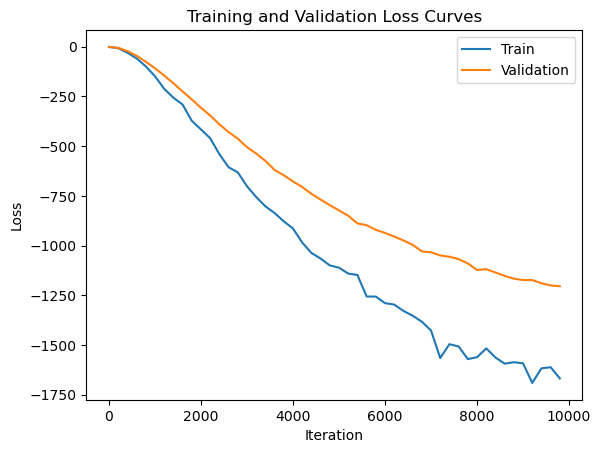

In [74]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='Train')
plt.plot(iters, val_losses, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Recall, Precision and NDCG Plots

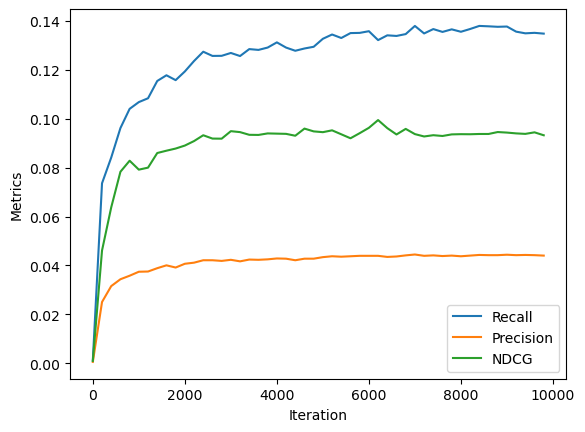

In [81]:
plt.plot(iters, val_recall_at_ks, label='Recall')
plt.plot(iters, val_precision, label='Precision')
plt.plot(iters, val_ndcg, label='NDCG')
plt.xlabel('Iteration')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Evaluation of Results

In [78]:
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -1200.48206, test_recall@20: 0.12623, test_precision@20: 0.04538, test_ndcg@20: 0.09474


## Reinitialize Model

In [42]:
model = LightGCN(num_users, num_items, embedding_dim=64, K=3)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model = model.to(device)
model.train() # Set model to training mode

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

## Updating Training Pipeline for Clustered Edge Index

In [43]:
N_CLUSTERS = 10

# INITIALIZE EMPTY LISTS
train_losses = []
val_losses = []
val_recall_at_ks = []
val_precision = []
val_ndcg = []

# START TRAINING LOOP
for iter in tqdm(range(ITERATIONS)):
    
    # RANDOMLY SAMPLE SET OF CLUSTERS, AGGREGATE TO CONSTRUCT AN INDUCED SUBGRAPH
    sampled_clusters = np.random.choice(range(n_clusters), size=N_CLUSTERS, replace=False)
    sampled_edge_index = torch.cat([clustered_train_edge_index[cluster] for cluster in sampled_clusters], dim=1)
    
    # FORWARD PROPAGATION (ON INDUCED SUBGRAPH)
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, sampled_edge_index)
    
    # LOSS COMPUTATION
    train_loss = bpr_loss(users_emb_final, users_emb_0, 
                          pos_items_emb_final, pos_items_emb_0, 
                          neg_items_emb_final, neg_items_emb_0, 
                          LAMBDA)
    
    # BACKPROPAGATION AND UPDATE
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # VALIDATION SET -------------------------------------------
    # Perform the evaluation of model on validation set every ITERS_PER_EVAL iterations:
    
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        # COMPUTE VALIDATION LOSS, RECALL, PRECISION, AND NDCG
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                           val_edge_index, 
                                                           [train_edge_index], 
                                                           K, 
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            # APPEND LOSSES AND RECALL VALUES TO RESULTS
            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
            val_precision.append(round(precision, 5))
            val_ndcg.append(round(ndcg, 5))
            
        model.train()
        
    # ---------------------------------------------------------      
        
    # ADJUSTING LEARNING RATE WITH SCHEDULER
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69816, val_loss: -0.69952, val_recall@20: 0.00157, val_precision@20: 0.00063, val_ndcg@20: 0.001
[Iteration 200/10000] train_loss: -2.32697, val_loss: -2.50571, val_recall@20: 0.10132, val_precision@20: 0.03599, val_ndcg@20: 0.06538
[Iteration 400/10000] train_loss: -10.55312, val_loss: -11.88717, val_recall@20: 0.11471, val_precision@20: 0.04069, val_ndcg@20: 0.07857
[Iteration 600/10000] train_loss: -23.80523, val_loss: -25.67762, val_recall@20: 0.121, val_precision@20: 0.04268, val_ndcg@20: 0.08236
[Iteration 800/10000] train_loss: -37.81372, val_loss: -42.21241, val_recall@20: 0.12644, val_precision@20: 0.04376, val_ndcg@20: 0.08923
[Iteration 1000/10000] train_loss: -53.10799, val_loss: -61.2315, val_recall@20: 0.12866, val_precision@20: 0.04439, val_ndcg@20: 0.09141
[Iteration 1200/10000] train_loss: -78.57045, val_loss: -82.30348, val_recall@20: 0.13612, val_precision@20: 0.04467, val_ndcg@20: 0.0933
[Iteration 1400/10000] train_loss: -93.22414

## Training and Validation Loss Plots (Cluster Results)

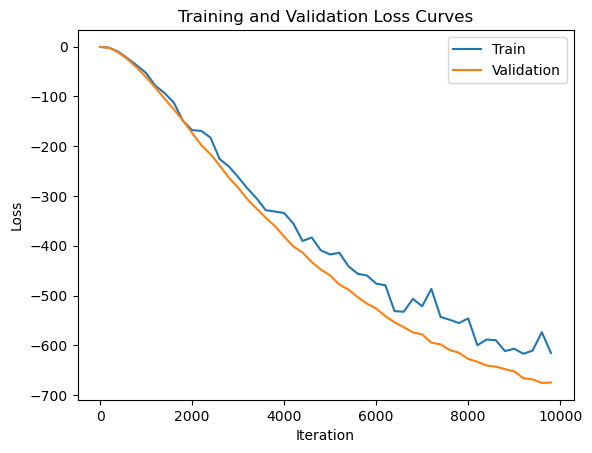

In [44]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='Train')
plt.plot(iters, val_losses, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Recall, Precision and NDCG Plots

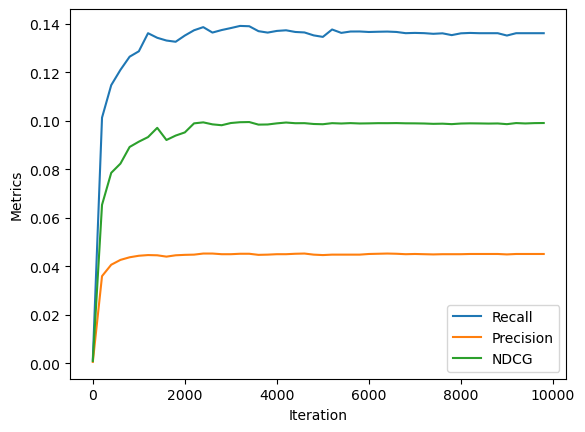

In [45]:
plt.plot(iters, val_recall_at_ks, label='Recall')
plt.plot(iters, val_precision, label='Precision')
plt.plot(iters, val_ndcg, label='NDCG')
plt.xlabel('Iteration')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Evaluation of Results (Cluster Results)

In [46]:
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -668.14313, test_recall@20: 0.11743, test_precision@20: 0.04493, test_ndcg@20: 0.09374
